# Data Preprocessing

This section explores the preprocessing steps that were carried out to clean the data and to produce a dataset with relevant information for exploratory and predictive data analysis.

**Highlights**

- Datatime formats did not match accross the dataset and contained multiple errors, these were standardized and corrected.
- Station IDs were inexistent for Q3 and Q4, these were matched with a new source of data from stations.
- Significant number of outliers were dealt with.
- Some null values were removed.


In [1]:
import warnings
warnings.filterwarnings('ignore')

# Basics
import pandas as pd
import numpy as np
import math
from datetime import datetime
import os

#Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import requests
import json
from fuzzywuzzy import process
from fuzzywuzzy import fuzz

## Loading

After extracting the zip file containing the datasets, we then read the files of interest.

In [2]:
os.listdir('../Data')

['Bikeshare Ridership (2017 Q1).csv',
 'Bikeshare Ridership (2017 Q2).csv',
 'Bikeshare Ridership (2017 Q3).csv',
 'Bikeshare Ridership (2017 Q4).csv',
 'daily_temp.csv',
 'eng-daily-01012017-12312017.csv',
 'hourly_temp.csv']

In [3]:
# List all the files available related to bikeshare
data_files = [file_name for file_name in os.listdir('../Data') if file_name.startswith('B')]

In [4]:
# Read files into dictionary of dataframes
bike_dict = {file_name: pd.read_csv(f'../Data/{file_name}') for file_name in data_files}

In [5]:
# Check if column names are consistent for all files
{key: df.columns.to_list() for key, df in bike_dict.items()}

{'Bikeshare Ridership (2017 Q1).csv': ['trip_id',
  'trip_start_time',
  'trip_stop_time',
  'trip_duration_seconds',
  'from_station_id',
  'from_station_name',
  'to_station_id',
  'to_station_name',
  'user_type'],
 'Bikeshare Ridership (2017 Q2).csv': ['trip_id',
  'trip_start_time',
  'trip_stop_time',
  'trip_duration_seconds',
  'from_station_id',
  'from_station_name',
  'to_station_id',
  'to_station_name',
  'user_type'],
 'Bikeshare Ridership (2017 Q3).csv': ['trip_id',
  'trip_start_time',
  'trip_stop_time',
  'trip_duration_seconds',
  'from_station_name',
  'to_station_name',
  'user_type'],
 'Bikeshare Ridership (2017 Q4).csv': ['trip_id',
  'trip_start_time',
  'trip_stop_time',
  'trip_duration_seconds',
  'from_station_name',
  'to_station_name',
  'user_type']}

We see that for Q3 and Q4 we have two fields missing: `from_station_id` and `to_station_id`. We will have to deal with this in the future.

## Aggregating the data 

In [6]:
# First let's check the total number of rows
sum([df.shape[0] for _, df in bike_dict.items()])

1492369

In [7]:
# Create first dataframe
bike_df = bike_dict['Bikeshare Ridership (2017 Q1).csv'].copy()

#Iterate over dictionary and append to first dataframe
i=0
for key, df in bike_dict.items():
    if i!=0:
        bike_df = bike_df.append(df)
    i+=1

In [8]:
#Check shape again
bike_df.shape[0]

1492369

In [9]:
bike_df.reset_index(inplace=True, drop=True)

The number of records matches correctly. Let's examine head and tail to verify that the fields were correctly merged for all dataframes:

In [10]:
display(bike_df.head(2))
display(bike_df.tail(2))

,from_station_id,from_station_name,to_station_id,to_station_name,trip_duration_seconds,trip_id,trip_start_time,trip_stop_time,user_type
0,7051.0,Wellesley St E / Yonge St Green P,7089.0,Church St / Wood St,223,712382,1/1/2017 0:00,1/1/2017 0:03,Member
1,7143.0,Kendal Ave / Bernard Ave,7154.0,Bathurst Subway Station,279,712383,1/1/2017 0:00,1/1/2017 0:05,Member


,from_station_id,from_station_name,to_station_id,to_station_name,trip_duration_seconds,trip_id,trip_start_time,trip_stop_time,user_type
1492367,NaN,Phoebe St / Spadina Ave,NaN,Phoebe St / Spadina Ave,26,2383645,12/31/17 23:49:08,12/31/17 23:49:34,Member
1492368,NaN,Phoebe St / Spadina Ave,NaN,Simcoe St / Queen St W,480,2383646,12/31/17 23:49:41,12/31/17 23:57:41,Member


## Null Values

As seen, the dataset contains 9 columns and 1.492.369 records or trips. However, we will have some null values in Q3 and Q4 given non-existing columns (see `to_station_id` and `from_station_id`). These were created when all dataframes were appended together


In [11]:
#Get count of null registers
bike_df.isna().sum()

from_station_id          1026893
from_station_name              0
to_station_id            1026893
to_station_name                1
trip_duration_seconds          0
trip_id                        0
trip_start_time                0
trip_stop_time                 0
user_type                      0
dtype: int64

Let's take a look at the null values (different than the ones we know of)

In [11]:
bike_df[bike_df.to_station_name.isna()]

,from_station_id,from_station_name,to_station_id,to_station_name,trip_duration_seconds,trip_id,trip_start_time,trip_stop_time,user_type
1424602,NaN,Seaton St / Dundas St E,NaN,NaN,0,2302635,11/29/17 05:53:54,NULLNULL,Casual


This row is a trip that started at a specific station but has no destination, that could mean that the bicycle was not returned to any station. We will delete this one since there is no relevant information about the duration of the trip and the destination.

In [12]:
# Drop null row
bike_df.drop(index=bike_df[bike_df.to_station_name.isna()].index, inplace=True)

## Cleaning timestamps

After manually reviewing the dataset, we could observe that datetimes columns for each quarter were parsed differently with the following formats

```
date_formats = {
    '2017 Q1': ['%d/%m/%Y %H:%M', 0],
    '2017 Q2': ['%d/%m/%Y %H:%M', 0],
    '2017 Q3': ['%m/%d/%Y %H:%M', 0],  *
    '2017 Q4': ['%m/%d/%y %H:%M:%S', 0], *
}

```

\* These also have some string issues to deal with. First thing we do, is divide the dataset in two parts for proper preprocessing: `bike_df1` with Q1 and Q2 and `bike_df2` with Q3 and Q4.


In [13]:
#Split the data into two semesters for date correction
middle_index = 465475
bike_df1 = bike_df.loc[:middle_index,:]
bike_df2 = bike_df.loc[middle_index + 1:,:]

Then, a couple of functions are created to properly handle each of the dataframes aforementioned.

In [14]:
def format_date_type1(date):
    """Function for cleaning datetimes according to detected format for the first semester subset:
    Takes a date with format ['%d/%m/%Y %H:%M'] and returns a datetime object.
    
    >>> date = '1/1/2017 0:05'
    >>> format_date_type1(date).strftime('%d/%m/%Y %H:%M:%S')
    '01/01/2017 00:05:00'
    
    """
    
    formatted = datetime.strptime(date, '%d/%m/%Y %H:%M')
    return formatted

if __name__ == '__main__':
    import doctest
    doctest.run_docstring_examples(format_date_type1, globals())

In [15]:
def format_date_type2(date):
    """Function for cleaning the second semester subset, which is known to have some string issues
    along with two different formats for each Q, as stated before.
  
    Takes a date with any of the formats ['%m/%d/%Y %H:%M', 0] or ['%m/%d/%y %H:%M:%S', 0] and returns
    a d datetime object.

    >>> date = '7/1/2017 0:01'
    >>> format_date_type2(date).strftime('%d/%m/%Y %H:%M:%S')
    '01/07/2017 00:01:00'
    
    """  

    # Check for years detected within the dataset that are incorrect.
    not_wanted = ('2001', '2010', '2011', '2012')

    #Check if formatting is standard and belongs to the group of interest for applying pd.to_datetime function
    if not date.startswith(not_wanted):
        #Check first type of formatting
        try:
            formatted = datetime.strptime(date, '%m/%d/%y %H:%M:%S')
        except ValueError:
            #Check second type of formatting
            formatted = datetime.strptime(date, '%m/%d/%Y %H:%M')
    else:
      #Check first type of formatting
        try:
            formatted = datetime.strptime(date[2:], '%m/%d/%y %H:%M:%S')
        except ValueError:
            #Check second type of formatting
            formatted = datetime.strptime(date[2:], '%m-%d-%y %H:%M')

    return formatted

if __name__ == '__main__':
    import doctest
    doctest.run_docstring_examples(format_date_type2, globals())

Now we will vectorize both functions in order to apply it efficiently along the timestamp columns.

In [16]:
format_date_type1v = np.vectorize(format_date_type1)
format_date_type2v = np.vectorize(format_date_type2)

Apply datetime transformation for the first semester subset using the appropriate functions:

In [17]:
#Apply to two date columns
bike_df1['trip_start_time_f'] = format_date_type1v(bike_df1.trip_start_time)
bike_df1['trip_stop_time_f'] = format_date_type1v(bike_df1.trip_stop_time)

Now let's apply datetime transformation for the second semester subset with the second function:

In [18]:
#Apply to two date columns
bike_df2['trip_start_time_f'] = format_date_type2v(bike_df2.trip_start_time)
bike_df2['trip_stop_time_f'] = format_date_type2v(bike_df2.trip_stop_time)

**Test datetimes**

Now we will double-check that we have the years we want with the following tests:

* For fields `trip_start_time_f` and `trip_stop_time_f`, year should only be 2017 for the *first semester* (since we are only dealing with data from 2017)

In [19]:
[set([date.year for date in bike_df1.trip_start_time_f]), set([date.year for date in bike_df1.trip_stop_time_f])]

[{2017}, {2017}]

* For fields `trip_start_time_f` and `trip_stop_time_f`, year should be 2017 and 2017 and 2018, respectively, for the *second semester* (since some trips finish in 2018).

In [20]:
[set([date.year for date in bike_df2.trip_start_time_f]), set([date.year for date in bike_df2.trip_stop_time_f])]

[{2017}, {2017, 2018}]

**Check time continuiity**

Create a temporary column to verify the difference between one ``trip_start_time_f`` and the previous one. The difference shouldn't be negative for a sorted dataframe and shouldn't be more than 1 day (for overnight trips only).

In [21]:
# Concatenate dataframes
bike_df = pd.concat([bike_df1, bike_df2])

#Create desired column using the formatted start time
bike_df['temp_start_diff'] = bike_df.trip_start_time_f.dt.dayofyear.diff()

#Check for values different than zero or one
non_cont = bike_df.loc[(bike_df.temp_start_diff < 0) | (bike_df.temp_start_diff >1), :]

#Get number of non continuous registers
non_cont.shape[0]

16

Here, we can see that we have 16 registers with an odd behavior in which the continuity is not preserved. Let's explore these.

In [22]:
#Get one non continuous trip, previous and following
idx = non_cont.index[0]
bike_df.loc[idx-1:idx+1,:]

,from_station_id,from_station_name,to_station_id,to_station_name,trip_duration_seconds,trip_id,trip_start_time,trip_stop_time,user_type,trip_start_time_f,trip_stop_time_f,temp_start_diff
156831,7001.0,Lower Jarvis St / The Esplanade,7060.0,Princess St / Adelaide St,374,896854,12/4/2017 0:29,12/4/2017 0:35,Member,2017-04-12 00:29:00,2017-04-12 00:35:00,0.0
156832,7029.0,Bay St / Bloor St W,7025.0,Ted Rogers Way / Bloor St E,271,896859,11/4/2017 23:52,11/4/2017 23:57,Member,2017-04-11 23:52:00,2017-04-11 23:57:00,-1.0
156833,7029.0,Bay St / Bloor St W,7076.0,York St / Queens Quay W,909,896860,12/4/2017 0:21,12/4/2017 0:36,Member,2017-04-12 00:21:00,2017-04-12 00:36:00,1.0


After reviewing, it is not clear why these rows are flagged. We may calculate some statistics to check if those registers are outliers or present significant differences in relevant statistics compared to the whole dataframe.

In [23]:
pd.DataFrame([bike_df.trip_duration_seconds.describe().round(0), 
              non_cont.trip_duration_seconds.describe().round(0)],
            index=['full_df', 'non_cont_df'])

,count,mean,std,min,25%,50%,75%,max
full_df,1492368.0,1018.0,9773.0,1.0,415.0,654.0,1020.0,6382030.0
non_cont_df,16.0,620.0,417.0,60.0,414.0,490.0,706.0,1611.0


Other than the standard deviation, there are no significant differences overall, this is specially visible in the median. The mean and standard deviation are expected to vary given the presence of outliers in full dataset (read below). Given this, we will include this registers and reorder the dataframe by `trip_start_date_f`,

In [24]:
#Sort dataframe by date
bike_df.sort_values(by='trip_start_time_f', inplace=True)

Now that we have our dates properly formatted, let's drop `temp_start_diff`, `trip_start_time` and `trip_stop_time`

In [25]:
bike_df.drop(columns=['trip_start_time', 'trip_stop_time', 'temp_start_diff'], inplace=True)

With timestamps meeting the standards needed, we can move on and continue working with null values.

## Fixing Stations Data

We will connect to the Toronto Bike Share API to gather the stations data, in order to standardize and fix issues related to stations in our dataframe. First, we are going to use the information from the `station_information` endpoint to fix the stations data.

In [26]:
#Send get request
req = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')

Now get the stations data from the whole json object

In [27]:
#Get the json data as dataframe
stations_data = pd.DataFrame(json.loads(req.content)['data']['stations'])[['station_id', 'name', 'capacity', 'lat', 'lon']]

#Remove whitespaces
stations_data.name = stations_data.name.str.strip()
stations_data.head(1)

,station_id,name,capacity,lat,lon
0,7000,Fort York Blvd / Capreol Ct,35,43.639832,-79.395954


Last updated on

In [28]:
datetime.fromtimestamp(json.loads(req.content)['last_updated'])

datetime.datetime(2019, 12, 17, 8, 43, 26)

So this information is up to date (but with in a different timezone). However, we must check if the number of stations changed since 2017.

In [29]:
#Stations as of today
stations_data.name.shape

(462,)

For the record, this differs a bit from the information displayed on the website stating that 465 stations are available. Everything being in the right place, let's get the full list of stations used in 2017.

In [30]:
#Get the origin stations and IDs
start = bike_df[['from_station_id', 'from_station_name']]
start.columns = ['id', 'station']

#Get the destination stations and IDs
stop = bike_df[['to_station_id', 'to_station_name']]
stop.columns = ['id', 'station']

#Now let's merge those together to obtain names for stations in 2017
stations_2017 = pd.concat([start, stop]).drop_duplicates(['station']).sort_values(by='station').reset_index(drop=True)
stations_2017.station = stations_2017.station.str.strip()

In [31]:
#Inspect
stations_2017.head()

,id,station
0,NaN,111 Bond St (North of Dundas St E) - SMART
1,7071.0,161 Bleecker St (South of Wellesley)
2,7070.0,25 York St (ACC/Union Station South)
3,NaN,424 Wellington St W
4,7123.0,424 Wellington St. W


In [32]:
stations_2017.shape

(293, 2)

We have a total of 293 "unique" stations, however, we can see in the previous line that some of these stations are repeated with a slightly different name.

### Mapping station names to IDs 

For this mapping we will use three steps:

1. Brute-force string matching the 2017 station name to names in ``stations_data``
2. Use **fuzzywuzzy** to perform partial string matching of similar names and import fields from our ``stations_data``.
3. Those stations that are left and were not matched will be filled with `NaN` to indicate missing data.

In [33]:
def fix_null_station(station, choices):
    """This function will fix null stations by applying fuzzywuzy to the string and
    filtering those that do not meet a threshold of 80 or more according to wuzy partial
    ratio matching algorithm.

    Takes a station and a set of choices (which is the list of current stations) and 
    matches the string with the greatest score if it meets the criteria. It will return a 
    dictionary with the name, the index and the score of the station (if found).

    """

    #Create empty dictionary for storing station information
    stat_dict = {}
    new_score = None

    # Get the best match using fuzzywuzy
    best_match = process.extract(station, choices.name, limit=1, scorer=fuzz.partial_ratio)[0]

    # Check if match score above threshold and assign values accordingly
    if best_match[1] > 80:
        new_idx = best_match[2]
        new_station = best_match[0]
        new_score = best_match[1]
    else:
        new_idx = None
        new_station = station

    #Add data to dictionary and append to list
    stat_dict['idx'] = new_idx
    stat_dict['name'] = new_station
    stat_dict['score'] = new_score

    return(stat_dict)

Now we preprocess the `stations_2017` dataframe to get the data from the stations matched by means of one of the two methods (string matching or `fix_null_station` method) and non-matched.

In [34]:
stations_list = []

for row in stations_2017.itertuples():
  
    #Create a dictionary of station
    stat_dict = {}

    #Find the register through string matching only
    stat_data = stations_data.loc[stations_data.name == row[2],:].get_values()

    if stat_data.shape[0] > 0:

        #Assign data to dictionary if found
        stat_dict['idx'] = stat_data[0][0]
        stat_dict['name'] = stat_data[0][1]
        stat_dict['capacity'] = stat_data[0][2]
        stat_dict['lat'] = stat_data[0][3]
        stat_dict['lon'] = stat_data[0][4]
        stat_dict['matched'] = 'strmatch'
        stat_dict['score'] = 100

    else:

        #Get best match for station name using fuzzywuzy
        best_result = fix_null_station(row[2], stations_data)

        #Retrieve data from best match (if any)
        stat_data = stations_data.loc[stations_data.name == best_result['name'],:].get_values()

        if stat_data.shape[0] > 0:

            #Set values if exists    
            stat_dict['idx'] = stat_data[0][0]
            stat_dict['name'] = stat_data[0][1]
            stat_dict['capacity'] = stat_data[0][2]
            stat_dict['lat'] = stat_data[0][3]
            stat_dict['lon'] = stat_data[0][4]
            stat_dict['matched'] = 'fuzzywuzy'
            stat_dict['score'] = best_result['score']

        else:

            #Was not found
            stat_dict['idx'] = np.nan
            stat_dict['name'] = row[2]   #Set original name
            stat_dict['capacity'] = np.nan
            stat_dict['lat'] = np.nan
            stat_dict['lon'] = np.nan
            stat_dict['matched'] = 'No'
            stat_dict['score'] = np.nan

    # Append to list of dictionaries
    stations_list.append(stat_dict)

In [35]:
len(stations_list)

293

Now we have a list of dictionaries with all the information about each of the 293 stations extracted from the `stations_2017` dataframe, namely ID, name, capacity, latitude, longitude, if it was matched or not, and the score of the match if fuzzywuzy was used. Now let's turn it into a dataframe to get a full list of stations for the ridership data.

In [36]:
#Convert list of dictionaries into dataframe
stations_df = pd.DataFrame(stations_list)
stations_df.columns =['st_id', 'st_name', 'cap', 'lat', 'lon', 'matched', 'score']
stations_df.head(5)

,st_id,st_name,cap,lat,lon,matched,score
0,7268,111 Bond St (North of Dundas St E) - SMART,16.0,43.656927,-79.378497,strmatch,100.0
1,7071,161 Bleecker St (South of Wellesley),23.0,43.666233,-79.373327,strmatch,100.0
2,7033,Union Station,26.0,43.645609,-79.380386,fuzzywuzy,100.0
3,7123,424 Wellington St W,15.0,43.643834,-79.396649,strmatch,100.0
4,7123,424 Wellington St W,15.0,43.643834,-79.396649,fuzzywuzy,95.0


Now we are going to use this map to merge information about the capacity, ID, latitude, longitude and name of the station to our ``stations_2017`` dataframe to complete the information contained in it.

In [37]:
#Merge dataframes
stations_df = stations_2017.reset_index(drop=True).merge(stations_df.reset_index(drop=True), 
                                                         left_index=True, 
                                                         right_index=True)
#Display a bit
stations_df.head(2)

,id,station,st_id,st_name,cap,lat,lon,matched,score
0,NaN,111 Bond St (North of Dundas St E) - SMART,7268,111 Bond St (North of Dundas St E) - SMART,16.0,43.656927,-79.378497,strmatch,100.0
1,7071.0,161 Bleecker St (South of Wellesley),7071,161 Bleecker St (South of Wellesley),23.0,43.666233,-79.373327,strmatch,100.0


Now let's check if we have some inconsistencies in the mapping carried out.

In [38]:
#Check for null values
stations_df.loc[pd.isna(stations_df.st_id), :].reset_index(drop=True)

,id,station,st_id,st_name,cap,lat,lon,matched,score
0,7179.0,Bloor GO / UP Station/ Rail Path,NaN,Bloor GO / UP Station/ Rail Path,NaN,NaN,NaN,No,NaN
1,7061.0,Bloor St / Brunswick Ave,NaN,Bloor St / Brunswick Ave,NaN,NaN,NaN,No,NaN
2,7073.0,Bremner Blvd / Spadina Ave,NaN,Bremner Blvd / Spadina Ave,NaN,NaN,NaN,No,NaN
3,7068.0,Dockside Dr / Queens Quay E (Sugar Beach),NaN,Dockside Dr / Queens Quay E (Sugar Beach),NaN,NaN,NaN,No,NaN
4,NaN,Fringe Next Stage - 7219,NaN,Fringe Next Stage - 7219,NaN,NaN,NaN,No,NaN
5,NaN,Margueretta St / College St,NaN,Margueretta St / College St,NaN,NaN,NaN,No,NaN
6,7183.0,Margueretta St / College St W,NaN,Margueretta St / College St W,NaN,NaN,NaN,No,NaN
7,NaN,Michael Sweet Ave / St. Patrick St,NaN,Michael Sweet Ave / St. Patrick St,NaN,NaN,NaN,No,NaN
8,7171.0,Ontario Place Blvd / Remembrance Dr,NaN,Ontario Place Blvd / Remembrance Dr,NaN,NaN,NaN,No,NaN
9,NaN,Roxton Rd / College St,NaN,Roxton Rd / College St,NaN,NaN,NaN,No,NaN


After reviewing manually these registers, it turns out that most of these 13 stations no longer exist (according to BST data), the only two stations that were found and not matched by our algorithm were:

- 'Temperance St / Yonge St	' -> 'Temperance St. Station'
- 'Bloor GO / UP Station/ Rail Path	' -> 'Bloor GO / UP Station (West Toronto Railpath)'

To improve the score in these two, we will modify the `stations_df` data to replace these names in order to match for both of these stations to the map below. We are offering a little bit of help to the string matching algorithm.

In [39]:
#Stations to be replaced
str_dict = {'Temperance St / Yonge St': 'Temperance St. Station',
            'Bloor GO / UP Station/ Rail Path	': 'Bloor GO / UP Station (West Toronto Railpath)'}

# Find these stations and modify the stations_df map.
for key, value in str_dict.items():
  
    #Get index
    idx = stations_df.index[stations_df.station == key.strip()]
    value = value.strip()

    #Fill values manually
    stations_df.loc[idx, 'st_id'] = stations_data.station_id[stations_data.name == value].values[0]
    stations_df.loc[idx, 'st_name'] = stations_data.name[stations_data.name == value].values[0]
    stations_df.loc[idx, 'cap'] = stations_data.capacity[stations_data.name == value].values[0]
    stations_df.loc[idx, 'lat'] = stations_data.lat[stations_data.name == value].values[0]
    stations_df.loc[idx, 'lon'] = stations_data.lon[stations_data.name == value].values[0]
    stations_df.loc[idx, 'matched'] = 'No'
    stations_df.loc[idx, 'score'] = None

Check if it was corrected and we have two registers less in our dataframe.

In [40]:
stations_df.loc[pd.isna(stations_df.st_id), :].reset_index()

,index,id,station,st_id,st_name,cap,lat,lon,matched,score
0,32,7061.0,Bloor St / Brunswick Ave,NaN,Bloor St / Brunswick Ave,NaN,NaN,NaN,No,NaN
1,44,7073.0,Bremner Blvd / Spadina Ave,NaN,Bremner Blvd / Spadina Ave,NaN,NaN,NaN,No,NaN
2,85,7068.0,Dockside Dr / Queens Quay E (Sugar Beach),NaN,Dockside Dr / Queens Quay E (Sugar Beach),NaN,NaN,NaN,No,NaN
3,111,NaN,Fringe Next Stage - 7219,NaN,Fringe Next Stage - 7219,NaN,NaN,NaN,No,NaN
4,166,NaN,Margueretta St / College St,NaN,Margueretta St / College St,NaN,NaN,NaN,No,NaN
5,167,7183.0,Margueretta St / College St W,NaN,Margueretta St / College St W,NaN,NaN,NaN,No,NaN
6,173,NaN,Michael Sweet Ave / St. Patrick St,NaN,Michael Sweet Ave / St. Patrick St,NaN,NaN,NaN,No,NaN
7,180,7171.0,Ontario Place Blvd / Remembrance Dr,NaN,Ontario Place Blvd / Remembrance Dr,NaN,NaN,NaN,No,NaN
8,222,NaN,Roxton Rd / College St,NaN,Roxton Rd / College St,NaN,NaN,NaN,No,NaN
9,244,7084.0,Stephenson Ave / Main St,NaN,Stephenson Ave / Main St,NaN,NaN,NaN,No,NaN


Great, the two stations that we needed information from are now correct. Now it's time to map the values to the stations; for this, we will extract a subset of `stations_df` because not all the information is needed.

In [41]:
#Create the map to use
stations_map = stations_df[['station', 'st_id', 'st_name', 'lat', 'lon', 'cap']]
stations_map.station = stations_map.station.str.strip()
stations_map.head()

,station,st_id,st_name,lat,lon,cap
0,111 Bond St (North of Dundas St E) - SMART,7268,111 Bond St (North of Dundas St E) - SMART,43.656927,-79.378497,16.0
1,161 Bleecker St (South of Wellesley),7071,161 Bleecker St (South of Wellesley),43.666233,-79.373327,23.0
2,25 York St (ACC/Union Station South),7033,Union Station,43.645609,-79.380386,26.0
3,424 Wellington St W,7123,424 Wellington St W,43.643834,-79.396649,15.0
4,424 Wellington St. W,7123,424 Wellington St W,43.643834,-79.396649,15.0


Now, before we finally assign the new data to the ``bike_df`` main dataframe we are going to need a bit of string preprocessing

In [42]:
bike_df.from_station_name = bike_df.from_station_name.str.strip()
bike_df.to_station_name = bike_df.to_station_name.str.strip()

Merge the ``stations_map`` with our main ridership dataframe to fix the origin and destination information and attached extra data.

In [43]:
bike_df = bike_df.merge(stations_map,
                      how='left', 
                      left_on='from_station_name', 
                      right_on='station')\
                  .merge(stations_map, 
                      how='left', 
                      left_on='to_station_name', 
                      right_on='station', suffixes = ('_orig','_dest'))

Now let's see if there were any stations left to match for the origin and destination stations.

In [44]:
bike_df.from_station_name[pd.isna(bike_df.st_id_orig)].nunique()

11

In [45]:
bike_df.to_station_name[pd.isna(bike_df.st_id_dest)].nunique()

11

This is expected since we saw before that we did not have any data for 11 stations (which are represented here). That is to say, the only null values that we have for non-matched stations are the ones we already know no longer exist. Now let's drop some unusefull columns from this wide dataset

In [46]:
bike_df.head(1)

,from_station_id,from_station_name,to_station_id,to_station_name,trip_duration_seconds,trip_id,user_type,trip_start_time_f,trip_stop_time_f,station_orig,...,st_name_orig,lat_orig,lon_orig,cap_orig,station_dest,st_id_dest,st_name_dest,lat_dest,lon_dest,cap_dest
0,7051.0,Wellesley St E / Yonge St Green P,7089.0,Church St / Wood St,223,712382,Member,2017-01-01,2017-01-01 00:03:00,Wellesley St E / Yonge St Green P,...,Wellesley St E / Yonge St (Green P),43.66506,-79.38357,17.0,Church St / Wood St,7089,Church St / Wood St,43.662712,-79.379903,19.0


In [47]:
bike_df.drop(columns=['station_orig', 'station_dest', 'from_station_id', 
                         'to_station_id', 'from_station_name', 'to_station_name'], inplace=True)

Now let's drop the trips with **unknown origin and destination** stations since those are not useful for our analysis

In [48]:
#How many of those registers we have?
bike_df.index[pd.isna(bike_df.st_id_orig) &  pd.isna(bike_df.st_id_dest)].nunique()

8494

In [49]:
#Drop
bike_df.drop(index=bike_df.index[pd.isna(bike_df.st_id_orig) &  pd.isna(bike_df.st_id_dest)], inplace=True)

**Partial station data**

We also have some data in which one of the two stations is unknown. We will perform some EDA on it to assess whether if we could omit it or not.

In [50]:
#Extract the partial records
partial_records = bike_df[pd.isna(bike_df.st_id_orig) | pd.isna(bike_df.st_id_dest)]

How are these partial records distributed during the year?

Text(0.5, 0, 'Months')

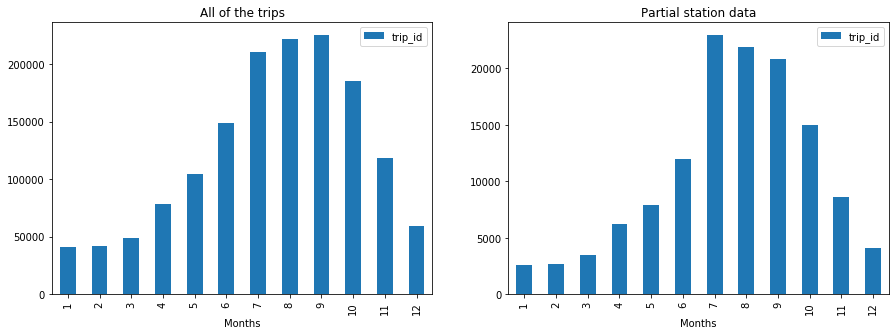

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Firtst plot the distribution of trips during the whole year
bike_df.groupby(bike_df.trip_start_time_f.dt.month).aggregate({'trip_id': 'count'}).plot(kind='bar', ax=ax[0])
ax[0].set_title('All of the trips')
ax[0].set_xlabel('Months')
partial_records.groupby(partial_records.trip_start_time_f.dt.month).aggregate({'trip_id': 'count'}).plot(kind='bar', ax=ax[1])
ax[1].set_title('Partial station data')
ax[1].set_xlabel('Months')

We can see that these are pretty much distributed similarly to the full dataset throughout the year, hence it will have a distributed impact on the analysis. 

However, even though the ``None`` stations no longer exist, and under the assumption that **people using start stations would still take the service to go to another nearby station**, and **people arriving to stop destinations would still get there from any other destination**, we will not delete this data and use it for the analysis.

### Verifying trip duration

Since we already have a tidy dataset, it is worth the time verifying the ``trip_duration_seconds`` variable using our timestamps. We will create a new column to calculate the difference between the stop time and the start time, namely ``trip_stop_time_f`` and ``trip_start_time_f``

In [52]:
#Calculate the duration
bike_df['trip_duration'] = bike_df.trip_stop_time_f - bike_df.trip_start_time_f
#Convert it to seconds
bike_df['trip_duration'] = bike_df.trip_duration.dt.seconds

Let's look at some statistics for these two columns and compare:

In [53]:
pd.DataFrame([bike_df.trip_duration.divide(60).describe().round(1), bike_df.trip_duration_seconds.divide(60).describe().round(1)])

,count,mean,std,min,25%,50%,75%,max
trip_duration,1483874.0,16.2,33.8,0.0,7.0,11.0,17.0,1439.0
trip_duration_seconds,1483874.0,16.8,163.3,0.0,6.9,10.9,16.9,106367.2


We can see that the calculated information from `trip_duration` looks **more reliable**, we have less variance and less extreme outliers, hence, we will use this information instead of the `trip_duration_seconds` variable given in the dataset. Now we will drop the variable from the dataset

In [54]:
#Drop trip_duration_seconds
bike_df.drop(columns='trip_duration_seconds', inplace=True)

In [55]:
#Get the null values finally
bike_df.isna().sum()

trip_id                  0
user_type                0
trip_start_time_f        0
trip_stop_time_f         0
st_id_orig           62779
st_name_orig             0
lat_orig             62779
lon_orig             62779
cap_orig             62779
st_id_dest           65202
st_name_dest             0
lat_dest             65202
lon_dest             65202
cap_dest             65202
trip_duration            0
dtype: int64

These null values are the unknown start/stop stations in which its pair is known and, as discussed, this will be used during the analysis. Now we got ourselves a clean dataset to analyze.

In [56]:
bike_df.to_csv('../Data/bts_clean.csv',header=True, index=False)